In [1]:
#Filter latest set of patients by criterion. 
import h5py,os
import numpy as np
%matplotlib inline
DATAFOLDER ='/home/shalit/TDGM/data_scripts/shalit/data2/NIPS_files/'

def readFeatures(fname):
    return [t.strip() for t in open(fname).readlines()]
def readHDF5(fname,datasetname):
    print 'Loading: ',datasetname
    h5file = h5py.File(fname,mode ='r')
    data = h5file[datasetname].value
    print h5file.keys()
    h5file.close()
    return data

In [2]:
datapat    = readHDF5(DATAFOLDER+'T_patient.h5','T_patient')
datapatnew = readHDF5(DATAFOLDER+'T_patient_w_binned_labs.h5','T_patient_w_binned_labs')
datapat    = np.concatenate((datapat,datapatnew[:,:,40:]),2)
print 'Concatenated Dimensions: ',datapat.shape

datapat = datapat[:,50:,:]
patdict = readFeatures(DATAFOLDER+'patient_dictionary.txt')+readFeatures(DATAFOLDER+'patient_dictionary_binned_labs.txt')
print datapat.shape,len(patdict)

Loading:  T_patient
[u'T_patient']
Loading:  T_patient_w_binned_labs
[u'T_patient_w_binned_labs']
Concatenated Dimensions:  (46804, 104, 55)
(46804, 54, 55) 55


In [3]:
datadoc = readHDF5(DATAFOLDER+'T_doctor.h5','T_doctor')
datadoc = datadoc[:,50:,:]
docdict = readFeatures(DATAFOLDER+'doctor_dictionary.txt')
print datadoc.shape,len(docdict)

Loading:  T_doctor
[u'T_doctor']
(46804, 54, 78) 78


In [4]:
#Only consider a subset of indices
patkeep_idx = np.unique(np.array([1,2,3,4,5,6,7,14,8,9,11,21,26,12,16,18,25,29,39,19,40,31,23,15,22,38,28,17,30,\
                        37,37,20,34,27,35,24,33,32,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55])-1)
dockeep_idx = np.unique(np.array([68,53,51,50,64,67,74,59,66,70])-1) #Based on Torch Indexing, hence the -1 
#(had 15 in there (ALBUMIN))

patdict     = np.array(patdict)
datapatsmall = datapat[:,:,patkeep_idx]
patdictsmall = patdict[patkeep_idx]
print 'Patient:',datapatsmall.shape,len(patdictsmall)
docdict     = np.array(docdict)
datadocsmall = datadoc[:,:,dockeep_idx]
docdictsmall = docdict[dockeep_idx]
print 'Doctor:',datadocsmall.shape,len(docdictsmall)
mids = np.array(readFeatures(DATAFOLDER+'patient_list.txt'))
print 'MIDS:',len(mids)

Patient: (46804, 54, 52) 52
Doctor: (46804, 54, 10) 10
MIDS: 46804


In [5]:
print docdictsmall,patdictsmall

['INSULIN ASPART' 'INSULIN GLARGINE,HUM.REC.ANLOG' 'INSULIN DETEMIR'
 'SITAGLIPTIN PHOSPHATE' 'GLYBURIDE' 'GLIPIZIDE' 'GLIMEPIRIDE'
 'REPAGLINIDE' 'METFORMIN HCL' 'PIOGLITAZONE HCL'] ['age_lt49' 'age_lt57' 'age_lt63' 'age_lt70' 'age_lt98' 'gender_isF'
 'coverage' 'A1C_indicator' 'A1C_high' 'Gluc_indicator' 'Gluc_high'
 'DMII wo cmp nt st uncntrn' 'DMI wo cmp nt st uncntrln'
 'DMII wo cmp uncntrldn' 'Gout NOSn' 'Obesity NOSn' 'Morbid obesityn'
 'Anemia in chr kidney disn' 'Obstructive sleep apnean'
 'Malignant hypertensionn' 'Benign hyp ht dis w/o hfn'
 'Hyp hrt dis NOS w/o hfn' 'Cor ath unsp vsl ntv/gftn'
 'Crnry athrscl natve vssln' 'Chr ischemic hrt dis NOSn'
 'Prim cardiomyopathy NECn' 'CHF NOSn' 'Ocl crtd art wo infrctn'
 'Periph vascular dis NOSn' 'Pleural effusion NOSn'
 'Acute kidney failure NOSn' 'Chr kidney dis stage IIIn'
 'End stage renal diseasen' 'Renal & ureteral dis NOSn' 'Sleep apnea NOSn'
 'Impaired fasting glucosen' 'Abnormal glucose NECn' 'A1C_indicator'
 'a1c_lt_5.5

In [6]:
#Remove patients with no actions and no drug information
remove_noactions = True
if remove_noactions:
    data_sub = datadocsmall.sum(1).sum(1)
    idx = np.where(data_sub>0)[0]
    print 'Patients with >0 actions: ',len(idx),' keeping them...'
    datapatfiltered_tmp = datapatsmall[idx,:,:]
    datadocfiltered_tmp = datadocsmall[idx,:,:]
    mids_filtered_tmp = mids[idx]

    print 'Doctor:',datadocfiltered_tmp.shape,len(docdictsmall)
    print 'Patient:',datapatfiltered_tmp.shape,len(patdictsmall)
    print 'MIDS:',len(mids_filtered_tmp)

    data_sub = datadocfiltered_tmp.sum(1).sum(1)
    idx = np.where(data_sub>0)[0]
    print 'Keeping ',idx.shape[0],' patients with >0 drug information'
    datapatfiltered = datapatfiltered_tmp[idx,:,:]
    datadocfiltered = datadocfiltered_tmp[idx,:,:]
    mids_filtered = mids_filtered_tmp[idx]
else:
    datadocfiltered = datadocsmall
    datapatfiltered = datapatsmall
    mids_filtered   = mids
print datadocfiltered.shape,len(docdictsmall)
print datapatfiltered.shape,len(patdictsmall)
print len(mids_filtered)

Patients with >0 actions:  12355  keeping them...
Doctor: (12355, 54, 10) 10
Patient: (12355, 54, 52) 52
MIDS: 12355
Keeping  12355  patients with >0 drug information
(12355, 54, 10) 10
(12355, 54, 52) 52
12355


In [7]:
#Combine insulins
print 'OLD: ',docdictsmall,len(docdictsmall)
newdocdict    = []
newdoctordata = np.zeros((datadocfiltered.shape[0],datadocfiltered.shape[1],8))

newdoctordata[:,:,0] = datadocfiltered[:,:,0]+datadocfiltered[:,:,1]+datadocfiltered[:,:,2]
newdocdict.append('INSULIN GROUPED')
newdoctordata[:,:,1] = datadocfiltered[:,:,3]
newdocdict.append(docdictsmall[3])
newdoctordata[:,:,2] = datadocfiltered[:,:,4]
newdocdict.append(docdictsmall[4])
newdoctordata[:,:,3] = datadocfiltered[:,:,5]
newdocdict.append(docdictsmall[5])
newdoctordata[:,:,4] = datadocfiltered[:,:,6]
newdocdict.append(docdictsmall[6])
newdoctordata[:,:,5] = datadocfiltered[:,:,7]
newdocdict.append(docdictsmall[7])
newdoctordata[:,:,6] = datadocfiltered[:,:,8]
newdocdict.append(docdictsmall[8])
newdoctordata[:,:,7] = datadocfiltered[:,:,9]
newdocdict.append(docdictsmall[9])

newdoctordata[newdoctordata>1]=1
print newdoctordata.shape
print 'NEW:' , newdocdict,len(newdocdict)

OLD:  ['INSULIN ASPART' 'INSULIN GLARGINE,HUM.REC.ANLOG' 'INSULIN DETEMIR'
 'SITAGLIPTIN PHOSPHATE' 'GLYBURIDE' 'GLIPIZIDE' 'GLIMEPIRIDE'
 'REPAGLINIDE' 'METFORMIN HCL' 'PIOGLITAZONE HCL'] 10
(12355, 54, 8)
NEW: ['INSULIN GROUPED', 'SITAGLIPTIN PHOSPHATE', 'GLYBURIDE', 'GLIPIZIDE', 'GLIMEPIRIDE', 'REPAGLINIDE', 'METFORMIN HCL', 'PIOGLITAZONE HCL'] 8


In [8]:
#Bin by K months
print datapatfiltered.shape,len(patdictsmall)
print newdoctordata.shape,len(newdocdict)

T = newdoctordata.shape[1]
K = 3
nbins = np.ceil(T/float(K)).astype('int')
print 'T:',T,' K:',K,' nbins:',nbins

patient_filtered = np.zeros((datapatfiltered.shape[0],nbins,datapatfiltered.shape[2]))
doctor_filtered = np.zeros((newdoctordata.shape[0],nbins,newdoctordata.shape[2]))

for idx,start_idx in enumerate(range(0,T,K)):
    end_idx = np.min([T,start_idx+K]).astype('int')
    print idx,start_idx,end_idx
    patient_filtered[:,idx,:] = datapatfiltered[:,start_idx:end_idx,:].sum(1)
    doctor_filtered[:,idx,:] = newdoctordata[:,start_idx:end_idx,:].sum(1)
patient_filtered[patient_filtered>1] = 1
doctor_filtered[doctor_filtered>1] = 1

print np.unique(doctor_filtered),np.unique(patient_filtered)

patdict_filtered = patdictsmall
docdict_filtered = newdocdict

print patient_filtered.shape,len(patdict_filtered)
print doctor_filtered.shape,len(docdict_filtered)

(12355, 54, 52) 52
(12355, 54, 8) 8
T: 54  K: 3  nbins: 18
0 0 3
1 3 6
2 6 9
3 9 12
4 12 15
5 15 18
6 18 21
7 21 24
8 24 27
9 27 30
10 30 33
11 33 36
12 36 39
13 39 42
14 42 45
15 45 48
16 48 51
17 51 54
[ 0.  1.] [ 0.  1.]
(12355, 18, 52) 52
(12355, 18, 8) 8


In [11]:
def searchDict(searchstr,datadict):
    for idx,k in enumerate(datadict):
        if searchstr in k:
            return idx

#Remove patients without enough A1C information
A1Cidx = searchDict('indicator',patdict_filtered)
print patdict_filtered[A1Cidx]
patient_stats =  patient_filtered[:,:,A1Cidx].sum(1)
print patient_stats.shape


#RAHUL Originally 2, now 1, now 0
idx_to_keep = np.where(patient_stats>3)[0]
print idx_to_keep.shape[0]
print 'Patients with 0 A1C indicators across time: ',np.where(patient_stats==0)[0].shape[0]
print 'Patients with 1 A1C indicators across time: ',np.where(patient_stats==1)[0].shape[0]
print 'Patients with 2 A1C indicators across time: ',np.where(patient_stats==2)[0].shape[0]
print 'Patients with >3 A1C indicators across time: ',np.where(patient_stats>3)[0].shape[0]

print 'Removing patients with 0 A1C indicators'
datapatfiltered_final = patient_filtered[idx_to_keep,:,:]
datadocfiltered_final = doctor_filtered[idx_to_keep,:,:]
mids_filtered_final = mids_filtered[idx_to_keep]

print datapatfiltered_final.shape,len(patdict_filtered)
print datadocfiltered_final.shape,len(docdict_filtered)
print len(mids_filtered_final)

#Number of patients with 0 actions
print '#Patients remaining = ',len(np.where(datadocfiltered_final.sum(1).sum(1)>0)[0])

A1C_indicator
(12355,)
2502
Patients with 0 A1C indicators across time:  4111
Patients with 1 A1C indicators across time:  2311
Patients with 2 A1C indicators across time:  1971
Patients with >3 A1C indicators across time:  2502
Removing patients with 0 A1C indicators
(2502, 18, 52) 52
(2502, 18, 8) 8
2502
#Patients remaining =  2502


In [12]:
print datapatfiltered_final.shape, datadocfiltered_final.shape
print patdict_filtered

(2502, 18, 52) (2502, 18, 8)
['age_lt49' 'age_lt57' 'age_lt63' 'age_lt70' 'age_lt98' 'gender_isF'
 'coverage' 'A1C_indicator' 'A1C_high' 'Gluc_indicator' 'Gluc_high'
 'DMII wo cmp nt st uncntrn' 'DMI wo cmp nt st uncntrln'
 'DMII wo cmp uncntrldn' 'Gout NOSn' 'Obesity NOSn' 'Morbid obesityn'
 'Anemia in chr kidney disn' 'Obstructive sleep apnean'
 'Malignant hypertensionn' 'Benign hyp ht dis w/o hfn'
 'Hyp hrt dis NOS w/o hfn' 'Cor ath unsp vsl ntv/gftn'
 'Crnry athrscl natve vssln' 'Chr ischemic hrt dis NOSn'
 'Prim cardiomyopathy NECn' 'CHF NOSn' 'Ocl crtd art wo infrctn'
 'Periph vascular dis NOSn' 'Pleural effusion NOSn'
 'Acute kidney failure NOSn' 'Chr kidney dis stage IIIn'
 'End stage renal diseasen' 'Renal & ureteral dis NOSn' 'Sleep apnea NOSn'
 'Impaired fasting glucosen' 'Abnormal glucose NECn' 'A1C_indicator'
 'a1c_lt_5.5' 'a1c_lt_6' 'a1c_lt_6.5' 'a1c_lt_7' 'a1c_lt_8' 'a1c_lt_9'
 'a1c_lt_10' 'a1c_lt_19' 'Gluc_indicator' 'gluc_lt_92' 'gluc_lt_102'
 'gluc_lt_113' 'gluc_lt_13

In [13]:
a1cidx =  np.where(patdict_filtered=='A1C_indicator')[0].tolist()
a1c_hl,a1c_range = a1cidx[0],a1cidx[1]

a1c_high_val = np.where(['A1C_high' in k for k in patdict_filtered.tolist()])[0].tolist()
a1c_range_val= np.where(['a1c_lt' in k for k in patdict_filtered.tolist()])[0].tolist()
print 'A1c. HL:' ,a1c_hl, ' A1c. Hval',a1c_high_val, ' A1c. Range Ind',a1c_range,' A1c. Range Val',a1c_range_val

glucidx =  np.where(patdict_filtered=='Gluc_indicator')[0].tolist()
gluc_hl,gluc_range = glucidx[0],glucidx[1]

gluc_high_val = np.where(['Gluc_high' in k for k in patdict_filtered.tolist()])[0].tolist()
gluc_range_val= np.where(['gluc_lt' in k for k in patdict_filtered.tolist()])[0].tolist()
print 'Gluc. HL:' ,gluc_hl, ' Gluc. Hval',gluc_high_val, ' Gluc. Range Ind',gluc_range,' Gluc. Range Val',gluc_range_val

remaining_idx = np.where([ ('c_lt' not in k and 'indicator' not in k and 'high' not in k) for k in patdict_filtered.tolist()])[0].tolist()
print 'Remaining',remaining_idx

obs_idx       = a1c_high_val+a1c_range_val+gluc_high_val+gluc_range_val+remaining_idx
print obs_idx

ind_idx       = [a1c_hl]+[a1c_range]*len(a1c_range_val)+[gluc_hl]+[gluc_range]*len(gluc_range_val)
print ind_idx

print ind_idx
print obs_idx[:len(ind_idx)]

all_idx = obs_idx + ind_idx
all_idx.sort()
print (np.sort(list(set(all_idx)))-np.array(range(len(patdict_filtered)))).sum(),' == 0'

A1c. HL: 7  A1c. Hval [8]  A1c. Range Ind 37  A1c. Range Val [38, 39, 40, 41, 42, 43, 44, 45]
Gluc. HL: 9  Gluc. Hval [10]  Gluc. Range Ind 46  Gluc. Range Val [47, 48, 49, 50, 51]
Remaining [0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
[8, 38, 39, 40, 41, 42, 43, 44, 45, 10, 47, 48, 49, 50, 51, 0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
[7, 37, 37, 37, 37, 37, 37, 37, 37, 9, 46, 46, 46, 46, 46]
[7, 37, 37, 37, 37, 37, 37, 37, 37, 9, 46, 46, 46, 46, 46]
[8, 38, 39, 40, 41, 42, 43, 44, 45, 10, 47, 48, 49, 50, 51]
0  == 0


In [14]:
patdata_final = datapatfiltered_final[:,:,obs_idx]

diff = len(obs_idx)-len(ind_idx)
print diff
inddata_final = np.concatenate([datapatfiltered_final[:,:,ind_idx],
                                np.ones((datapatfiltered_final.shape[0],datapatfiltered_final.shape[1],diff))],axis=2)
actdata_final = datadocfiltered_final
print patdata_final.shape,inddata_final.shape,actdata_final.shape
docdict_data_final = docdict_filtered
patdict_data_final = [patdict_filtered[k] for k in obs_idx]
inddict_data_final = [(patdict_filtered[k]+patdict_data_final[i]).replace('A1C_indicator','').replace('Gluc_indicator','')+'_ind' for i,k in enumerate(ind_idx)]
inddict_data_final+= ['None']*diff
print docdict_data_final,len(docdict_data_final)
print patdict_data_final,len(patdict_data_final)
print inddict_data_final,len(inddict_data_final)

33
(2502, 18, 48) (2502, 18, 48) (2502, 18, 8)
['INSULIN GROUPED', 'SITAGLIPTIN PHOSPHATE', 'GLYBURIDE', 'GLIPIZIDE', 'GLIMEPIRIDE', 'REPAGLINIDE', 'METFORMIN HCL', 'PIOGLITAZONE HCL'] 8
['A1C_high', 'a1c_lt_5.5', 'a1c_lt_6', 'a1c_lt_6.5', 'a1c_lt_7', 'a1c_lt_8', 'a1c_lt_9', 'a1c_lt_10', 'a1c_lt_19', 'Gluc_high', 'gluc_lt_92', 'gluc_lt_102', 'gluc_lt_113', 'gluc_lt_135', 'gluc_lt_989', 'age_lt49', 'age_lt57', 'age_lt63', 'age_lt70', 'age_lt98', 'gender_isF', 'coverage', 'DMII wo cmp nt st uncntrn', 'DMI wo cmp nt st uncntrln', 'DMII wo cmp uncntrldn', 'Gout NOSn', 'Obesity NOSn', 'Morbid obesityn', 'Anemia in chr kidney disn', 'Obstructive sleep apnean', 'Malignant hypertensionn', 'Benign hyp ht dis w/o hfn', 'Hyp hrt dis NOS w/o hfn', 'Cor ath unsp vsl ntv/gftn', 'Crnry athrscl natve vssln', 'Chr ischemic hrt dis NOSn', 'Prim cardiomyopathy NECn', 'CHF NOSn', 'Ocl crtd art wo infrctn', 'Periph vascular dis NOSn', 'Pleural effusion NOSn', 'Acute kidney failure NOSn', 'Chr kidney dis st

In [15]:
print 'Should be 0:',np.abs(patdata_final-(patdata_final*inddata_final)).max()

Should be 0: 0.0


/sontag-md3400/usr/local/pkg/python/2.7.6/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


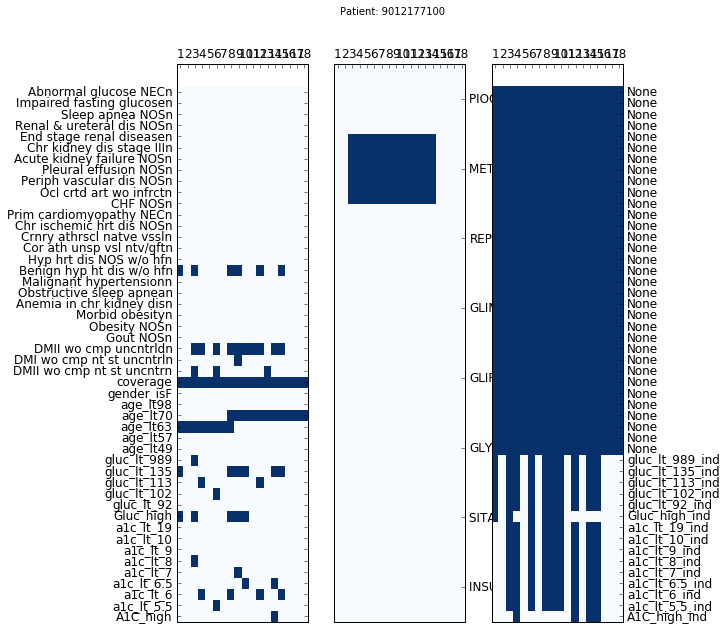

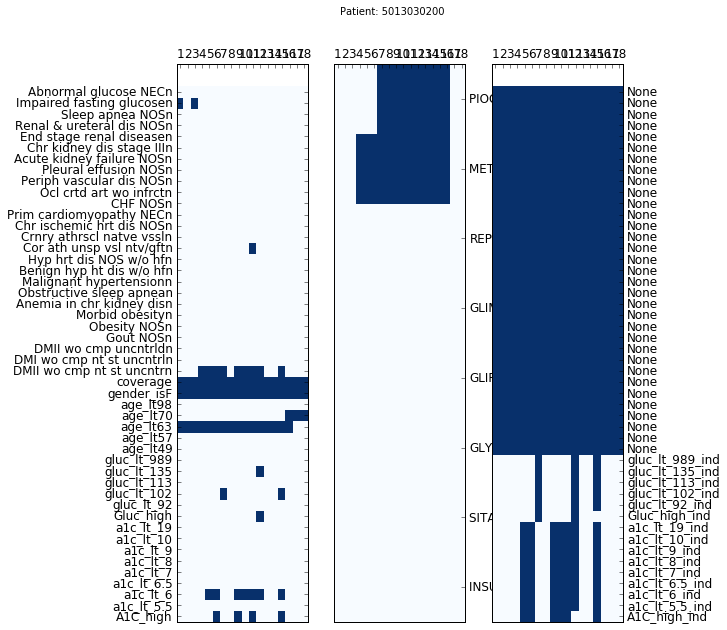

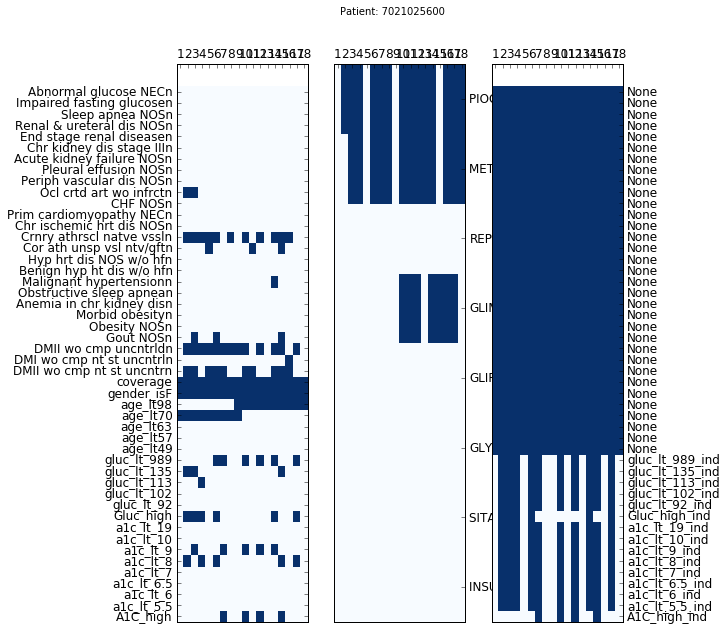

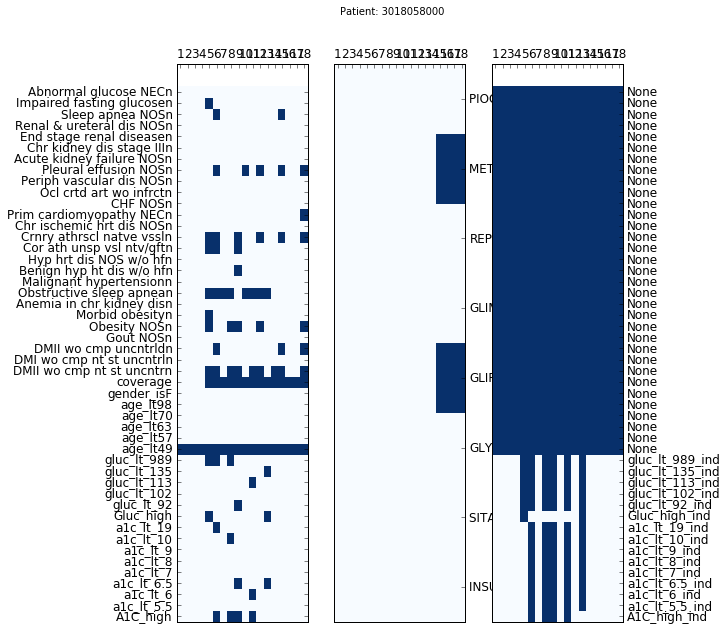

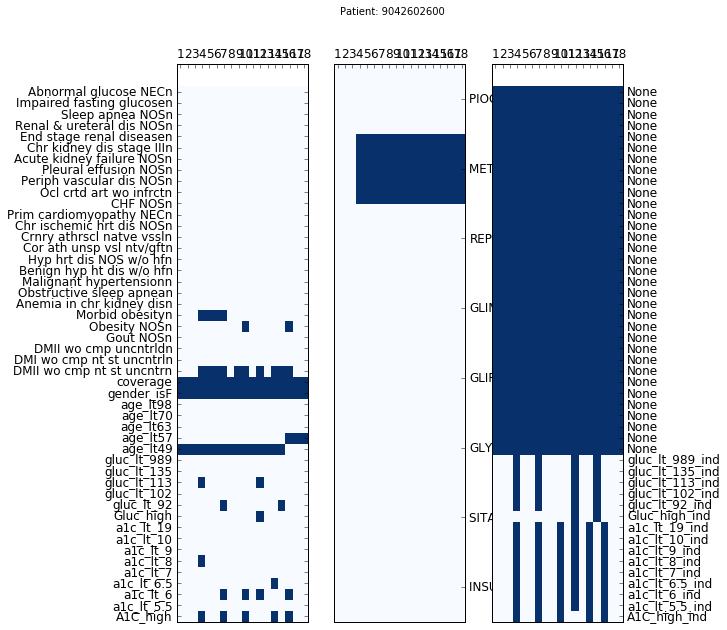

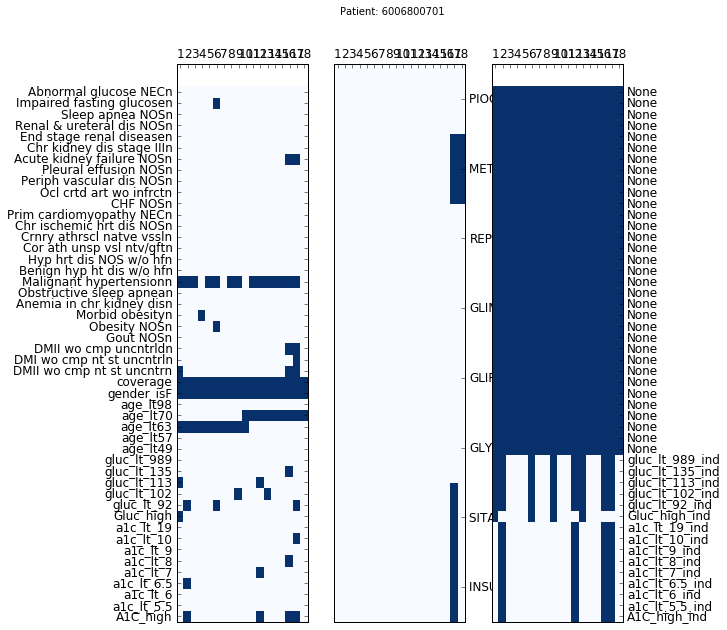

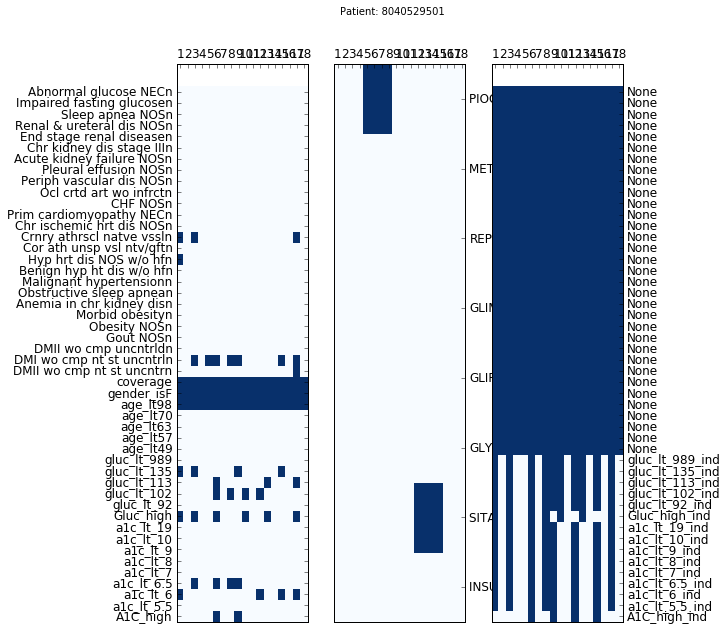

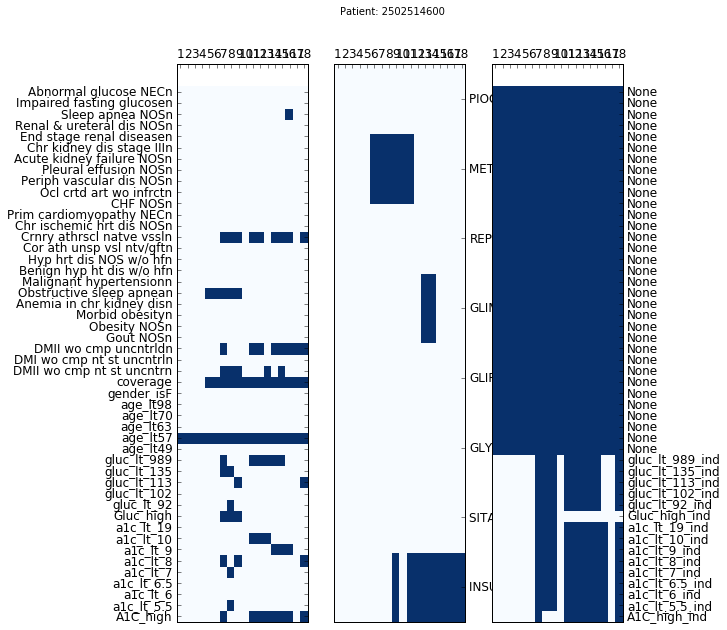

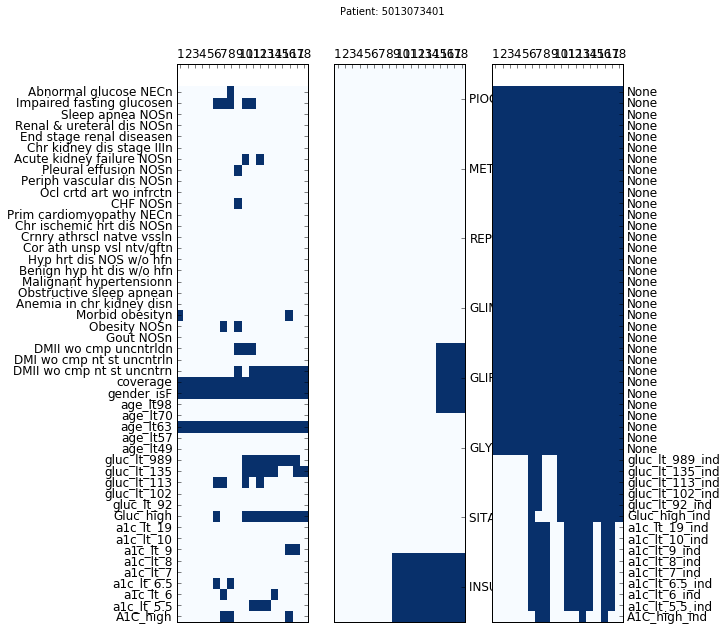

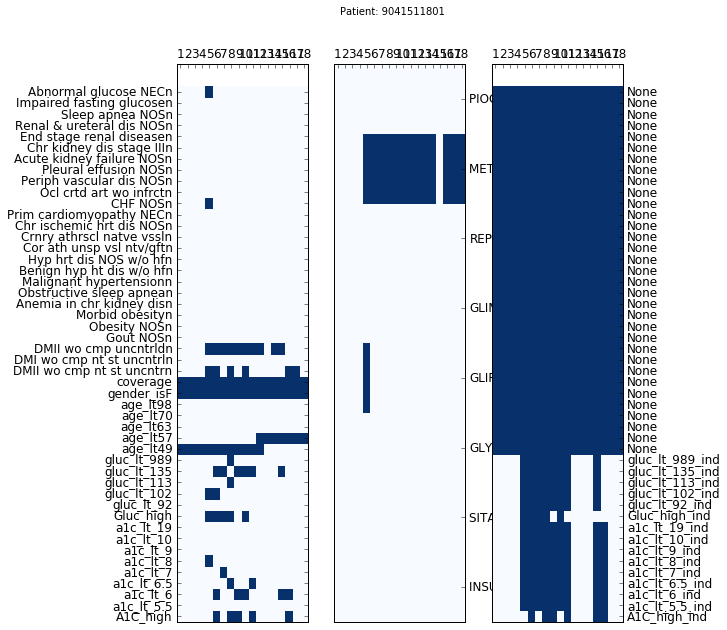

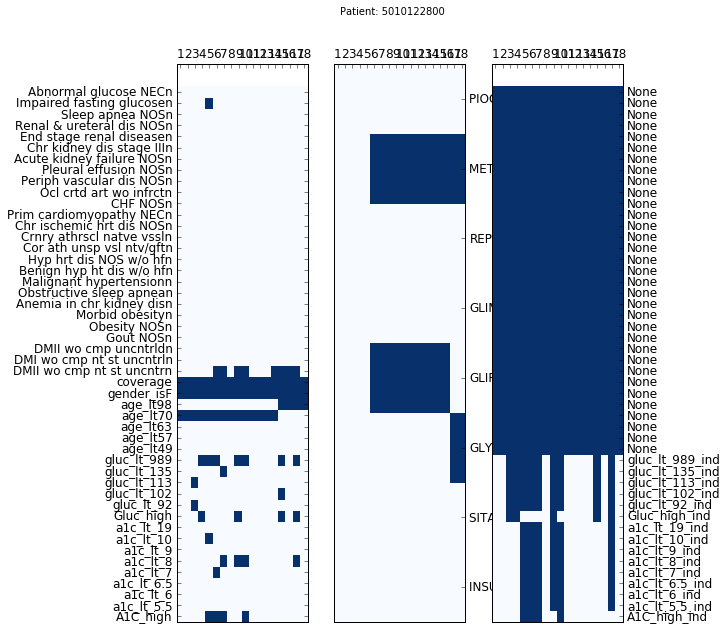

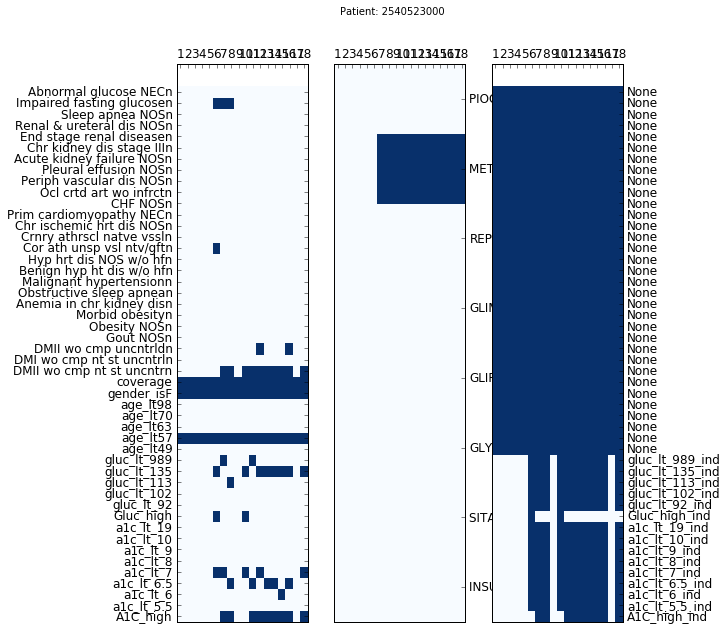

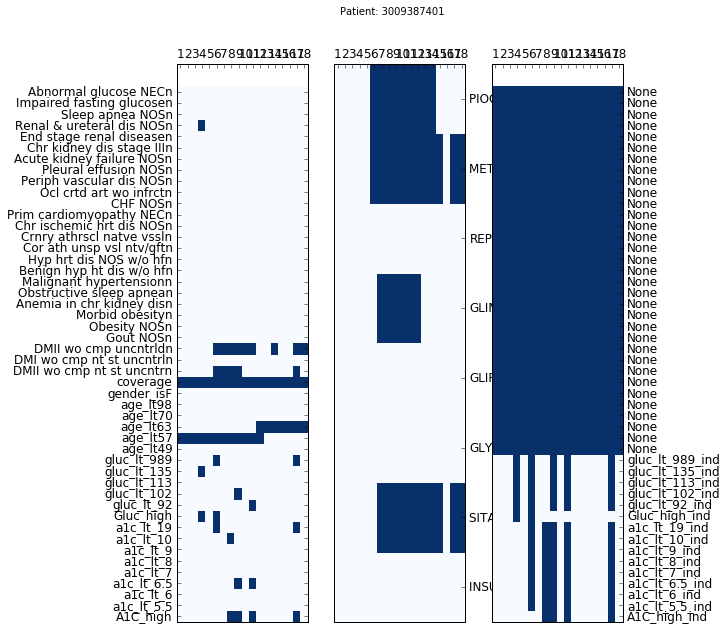

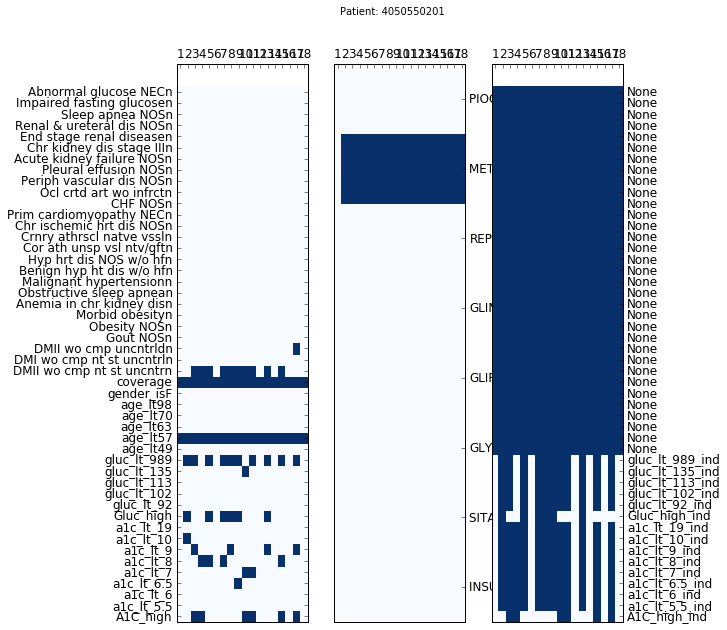

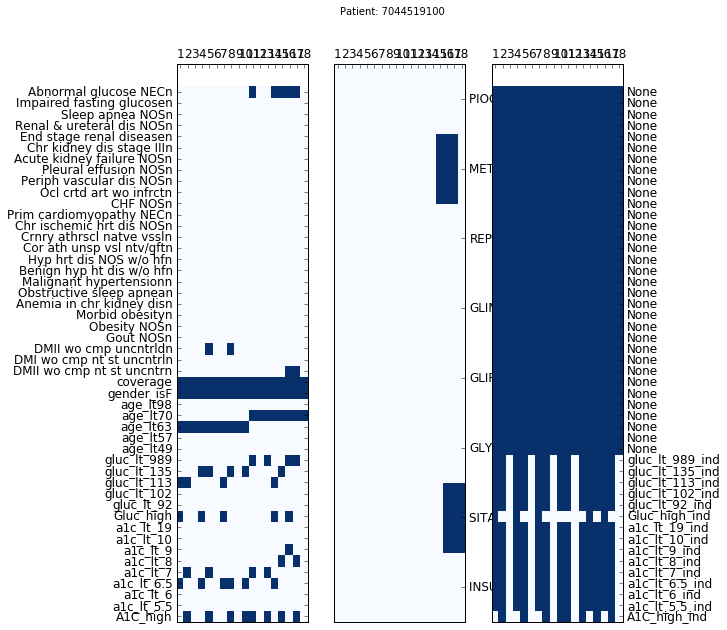

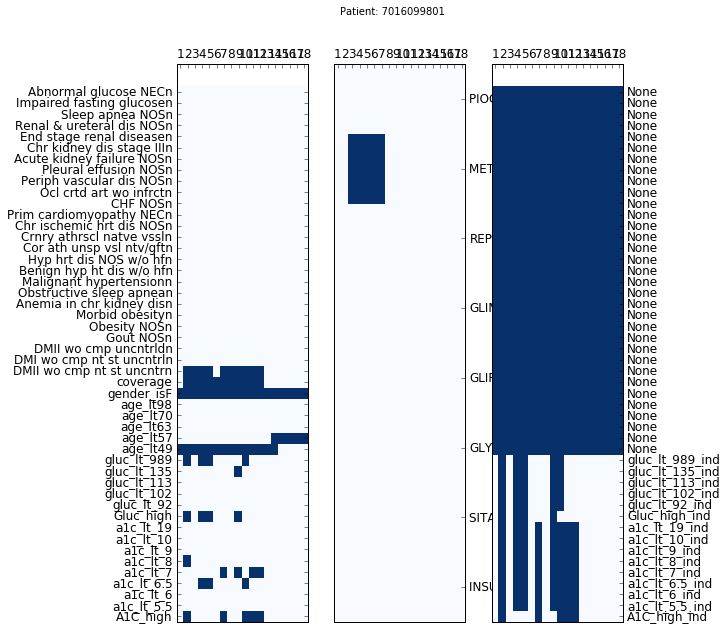

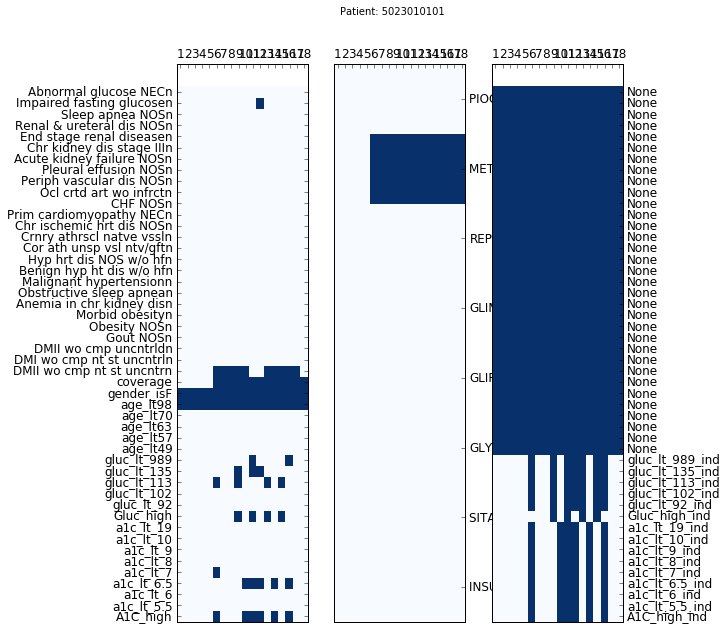

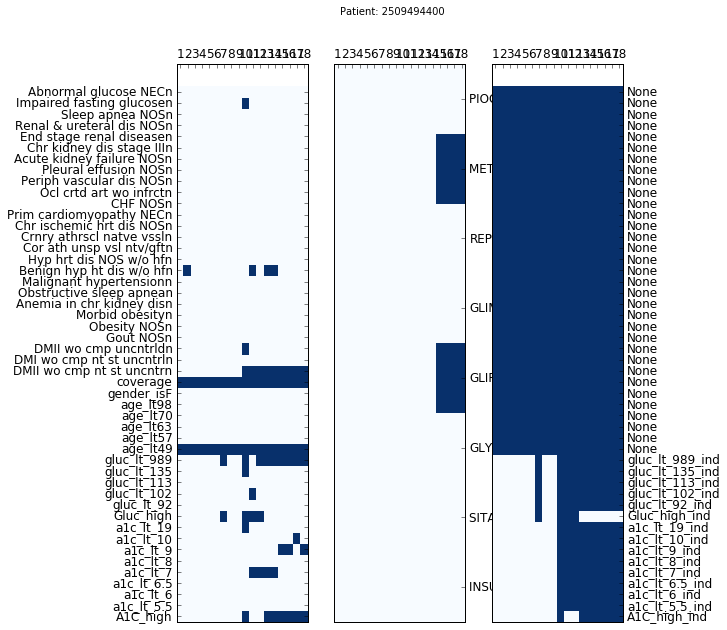

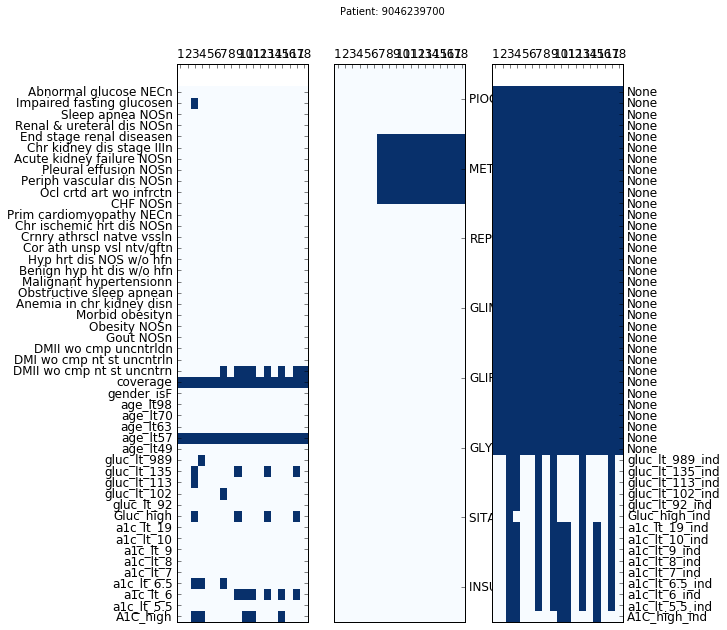

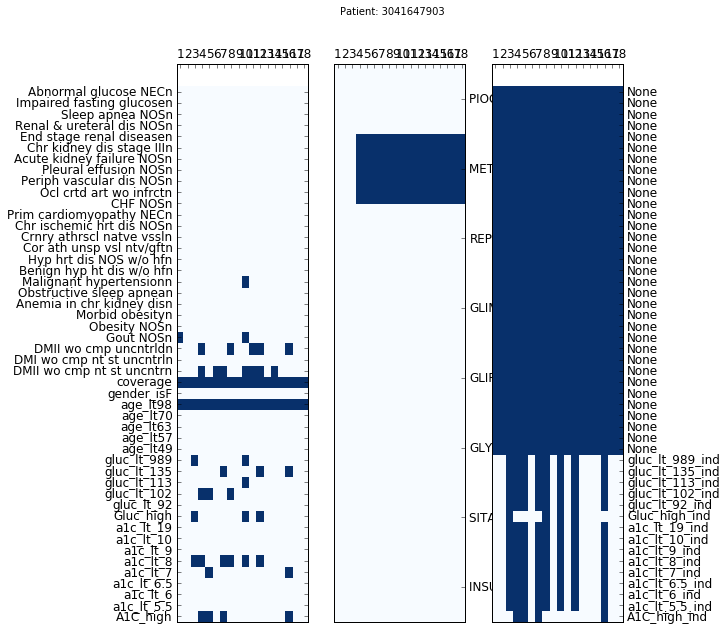

In [16]:
import matplotlib.pyplot as plt
import numpy as np
"""
patient_data = datapatfiltered_final
doctor_data = datadocfiltered_final
mids_data    = mids_filtered_final
patdict_data = patdict_filtered
docdict_data = docdict_filtered
"""
patient_data   = patdata_final
indicator_data = inddata_final
doctor_data    = actdata_final
mids_data      = mids_filtered_final
patdict_data   = patdict_data_final
inddict_data   = inddict_data_final
docdict_data   = docdict_data_final

shufidx = np.random.permutation(patient_data.shape[0])
for ctr in range(20):
    idx = shufidx[ctr]
    row_labels = patdict_data
    data = patient_data[idx,:,:]
    column_labels = range(1,data.shape[0]+1)
    fig, axlist = plt.subplots(1,3,figsize=(8,10))
    fig.suptitle('Patient: '+mids_data[idx])
    ax = axlist[0]
    heatmap = ax.pcolor(data.transpose(), cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)

    # want a more natural, table-like display
    #ax.invert_xaxis()
    ax.xaxis.tick_top()

    ax.tick_params(labelsize = 12)
    ax.set_xticklabels(column_labels, minor=False)
    ax.set_yticklabels(row_labels, minor=False)

    ax = axlist[1]
    data = doctor_data[idx,:,:]
    column_labels = range(1,data.shape[0]+1)
    row_labels = docdict_data
    heatmap = ax.pcolor(data.transpose(), cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)

    # want a more natural, table-like display
    #ax.invert_xaxis()
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()

    ax.tick_params(labelsize = 12)
    ax.set_xticklabels(column_labels, minor=False)
    ax.set_yticklabels(row_labels, minor=False)
    
    ax = axlist[2]
    data = indicator_data[idx,:,:]
    column_labels = range(1,data.shape[0]+1)
    row_labels = inddict_data
    heatmap = ax.pcolor(data.transpose(), cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)

    # want a more natural, table-like display
    #ax.invert_xaxis()
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()

    ax.tick_params(labelsize = 12)
    ax.set_xticklabels(column_labels, minor=False)
    ax.set_yticklabels(row_labels, minor=False)
    plt.show()

In [17]:
print DATAFOLDER

/home/shalit/TDGM/data_scripts/shalit/data2/NIPS_files/


In [22]:
SAVEFOLDER = '/m/users/rahul/structuredinference/medical_data/'
suffix = '_filtered'+str(K)+'months'+'_split'

np.random.seed(1)

idxlist = np.random.permutation(patient_data.shape[0])
ntest  = 800 #int(0.1*len(idxlist))
nvalid = int(0.02*len(idxlist))
ntrain = len(idxlist)-ntest-nvalid
print ntrain,nvalid,ntest

st_train  = 0
end_train = ntrain
st_valid  = ntrain
end_valid = ntrain+nvalid
st_test   = ntrain+nvalid
end_test  = ntrain+nvalid+ntest
print st_train,end_train,st_valid,end_valid,st_test,end_test,len(idxlist)

h5file = h5py.File(SAVEFOLDER+'data'+suffix+'.h5',mode ='w')
h5file['train_obs'] = patient_data[idxlist[st_train:end_train]]
h5file['train_act'] = doctor_data[idxlist[st_train:end_train]]
h5file['train_ind'] = indicator_data[idxlist[st_train:end_train]]

h5file['valid_obs'] = patient_data[idxlist[st_valid:end_valid]]
h5file['valid_act'] = doctor_data[idxlist[st_valid:end_valid]]
h5file['valid_ind'] = indicator_data[idxlist[st_valid:end_valid]]

h5file['test_obs']  = patient_data[idxlist[st_test:end_test]]
h5file['test_act']  = doctor_data[idxlist[st_test:end_test]]
h5file['test_ind']  = indicator_data[idxlist[st_test:end_test]]
h5file.close()

from utils.misc import loadHDF5
dd = loadHDF5(SAVEFOLDER+'data'+suffix+'.h5')
for k in dd:
    print k,dd[k].shape

with open(SAVEFOLDER+'patient_list'+suffix+'.txt','w') as f:
    f.write('\n'.join(mids_filtered_final.tolist()))

with open(SAVEFOLDER+'action_dictionary'+suffix+'.txt','w') as f:
    f.write('\n'.join(docdict_data))
with open(SAVEFOLDER+'observation_dictionary'+suffix+'.txt','w') as f:
    f.write('\n'.join(patdict_data))
with open(SAVEFOLDER+'indicator_dictionary'+suffix+'.txt','w') as f:
    f.write('\n'.join(inddict_data))

1652 50 800
0 1652 1652 1702 1702 2502 2502
test_obs (800, 18, 48)
train_obs (1652, 18, 48)
valid_ind (50, 18, 48)
valid_act (50, 18, 8)
test_ind (800, 18, 48)
train_ind (1652, 18, 48)
test_act (800, 18, 8)
valid_obs (50, 18, 48)
train_act (1652, 18, 8)
